In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [22]:


# Load data
df = pd.read_csv('course_lead_scoring.txt')  # Make sure this is the correct file

# Check the actual column names
print("Columns in dataset:", df.columns.tolist())
print("Data types:\n", df.dtypes)

# Data preparation - handle missing values
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

# Remove target from numerical columns if it's there
if 'converted' in numerical_columns:
    numerical_columns.remove('converted')

for col in categorical_columns:
    df[col] = df[col].fillna('NA')

for col in numerical_columns:
    df[col] = df[col].fillna(0.0)

# Split data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Columns in dataset: ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']
Data types:
 lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object
Training set size: 876
Validation set size: 293
Test set size: 293


In [23]:
# QUESTION 1 - Only use the specified 4 numerical variables
specified_numerical_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Verify these columns exist in your dataset
print("Available columns:", df.columns.tolist())
print("Looking for specified variables:", specified_numerical_vars)

auc_results = {}

for var in specified_numerical_vars:
    if var in df_train.columns:
        auc = roc_auc_score(df_train['converted'], df_train[var])
        
        if auc < 0.5:
            auc = roc_auc_score(df_train['converted'], -df_train[var])
            print(f"{var}: Inverted -> AUC = {auc:.4f}")
        else:
            print(f"{var}: AUC = {auc:.4f}")
        
        auc_results[var] = auc
    else:
        print(f"Warning: {var} not found in dataset")

if auc_results:
    best_variable = max(auc_results, key=auc_results.get)
    highest_auc = auc_results[best_variable]
    print(f"\nANSWER Q1: {best_variable} with AUC = {highest_auc:.4f}")

Available columns: ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']
Looking for specified variables: ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
lead_score: AUC = 0.6145
number_of_courses_viewed: AUC = 0.7636
interaction_count: AUC = 0.7383
annual_income: AUC = 0.5520

ANSWER Q1: number_of_courses_viewed with AUC = 0.7636


In [24]:
# QUESTION 2 - Reset indices and prepare data properly
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['converted'].values
y_val = df_val['converted'].values

# Remove target from features
X_train = df_train.drop('converted', axis=1)
X_val = df_val.drop('converted', axis=1)

# Convert to dictionaries
train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')

# Apply DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dict)
X_val_encoded = dv.transform(val_dict)

# Train model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Predictions
y_pred = model.predict_proba(X_val_encoded)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_val, y_pred)
print(f"ANSWER Q2: AUC = {auc_score:.3f}")

# Compare with options
options_q2 = [0.32, 0.52, 0.72, 0.92]
closest_option = min(options_q2, key=lambda x: abs(x - auc_score))
print(f"Closest option: {closest_option}")

ANSWER Q2: AUC = 0.817
Closest option: 0.72


ANSWER Q3: Intersection at threshold = 0.98


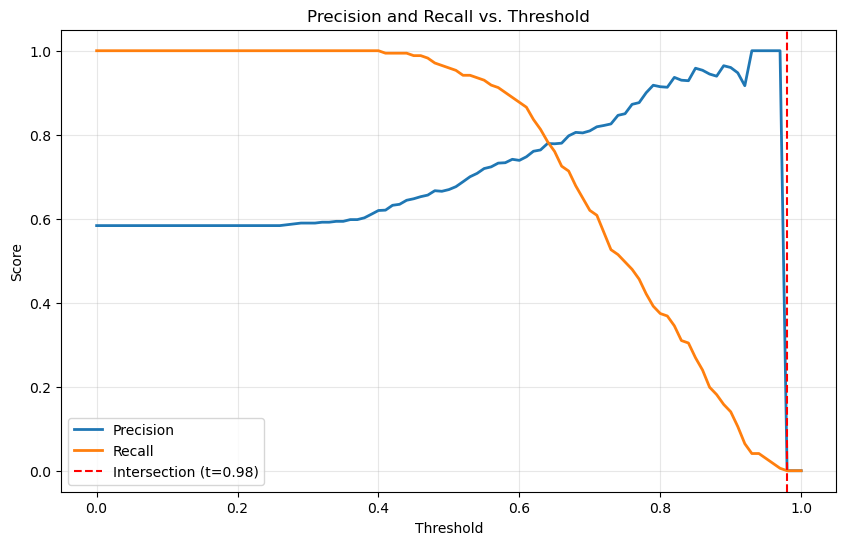

In [25]:
# QUESTION 3 - Precision and Recall
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_binary = (y_pred >= t).astype(int)
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)

# Find intersection (where difference is minimal)
differences = np.abs(np.array(precisions) - np.array(recalls))
intersection_idx = np.argmin(differences)
intersection_threshold = thresholds[intersection_idx]

print(f"ANSWER Q3: Intersection at threshold = {intersection_threshold:.2f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.axvline(x=intersection_threshold, color='red', linestyle='--', 
            label=f'Intersection (t={intersection_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Using manual F1 calculation:
Maximum F1 score: 0.8125 at threshold: 0.57
At this threshold:
  Precision: 0.7324
  Recall: 0.9123

Using sklearn F1 score:
Maximum F1 score: 0.8125 at threshold: 0.57

Top 5 thresholds with highest F1 scores:
    threshold  f1_score  precision  recall
57       0.57    0.8125     0.7324  0.9123
55       0.55    0.8112     0.7195  0.9298
56       0.56    0.8093     0.7235  0.9181
59       0.59    0.8085     0.7415  0.8889
58       0.58    0.8084     0.7333  0.9006


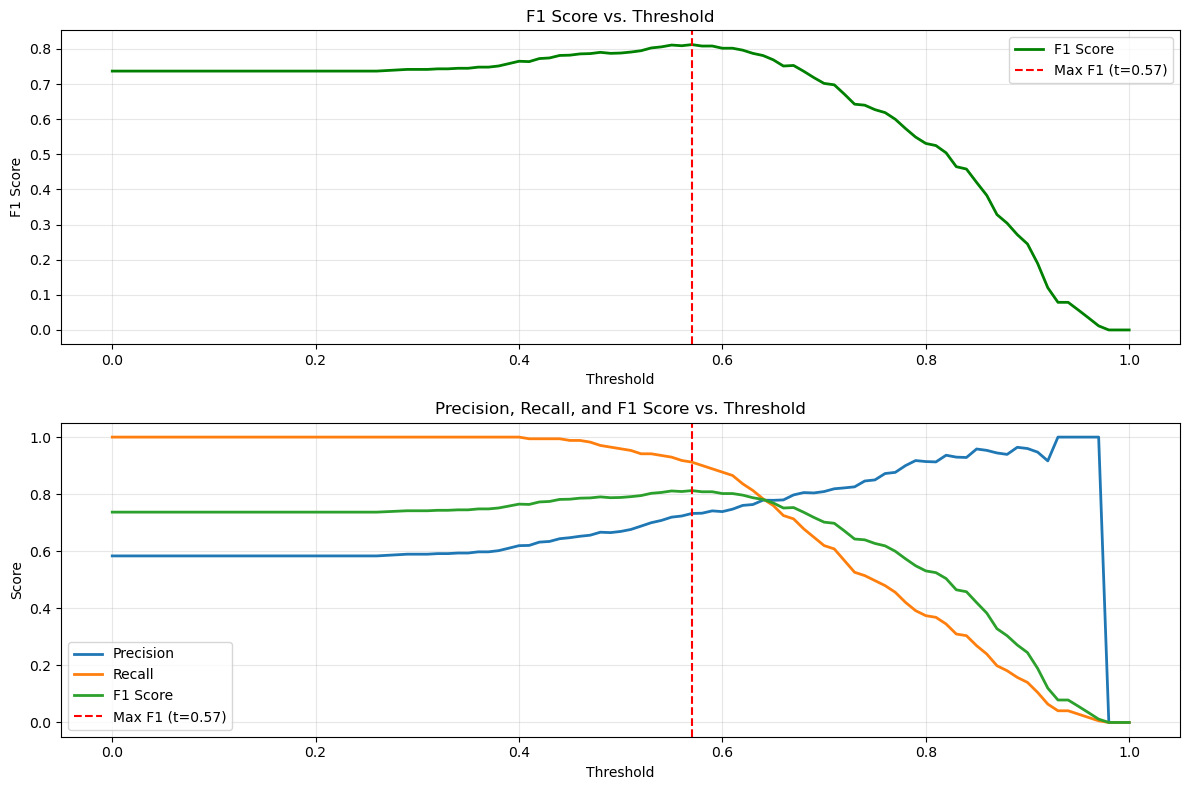


ANSWER Q4: The F1 score is maximal at threshold: 0.57


In [26]:
from sklearn.metrics import f1_score

# Assuming you have y_val and y_pred from previous steps

# Create thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Initialize lists to store F1 scores and other metrics
f1_scores = []
precisions = []
recalls = []

# Compute F1 score for each threshold
for t in thresholds:
    # Convert probabilities to binary predictions using threshold
    y_pred_binary = (y_pred >= t).astype(int)
    
    # Compute precision and recall
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary, zero_division=0)
    
    # Compute F1 score using the formula
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Alternative method using sklearn's f1_score (should give same result)
f1_scores_sklearn = []
for t in thresholds:
    y_pred_binary = (y_pred >= t).astype(int)
    f1 = f1_score(y_val, y_pred_binary, zero_division=0)
    f1_scores_sklearn.append(f1)

# Find the threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

max_f1_idx_sklearn = np.argmax(f1_scores_sklearn)
max_f1_threshold_sklearn = thresholds[max_f1_idx_sklearn]
max_f1_score_sklearn = f1_scores_sklearn[max_f1_idx_sklearn]

print(f"Using manual F1 calculation:")
print(f"Maximum F1 score: {max_f1_score:.4f} at threshold: {max_f1_threshold:.2f}")
print(f"At this threshold:")
print(f"  Precision: {precisions[max_f1_idx]:.4f}")
print(f"  Recall: {recalls[max_f1_idx]:.4f}")

print(f"\nUsing sklearn F1 score:")
print(f"Maximum F1 score: {max_f1_score_sklearn:.4f} at threshold: {max_f1_threshold_sklearn:.2f}")

# Create a DataFrame for detailed analysis
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores,
    'f1_score_sklearn': f1_scores_sklearn,
    'precision': precisions,
    'recall': recalls
})

# Display the top 5 thresholds with highest F1 scores
print("\nTop 5 thresholds with highest F1 scores:")
top_5 = results_df.nlargest(5, 'f1_score')[['threshold', 'f1_score', 'precision', 'recall']].round(4)
print(top_5)

# Plot F1 score vs threshold
plt.figure(figsize=(12, 8))

# Plot 1: F1 score
plt.subplot(2, 1, 1)
plt.plot(thresholds, f1_scores, label='F1 Score', color='green', linewidth=2)
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', 
            label=f'Max F1 (t={max_f1_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: All three metrics together
plt.subplot(2, 1, 2)
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', 
            label=f'Max F1 (t={max_f1_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nANSWER Q4: The F1 score is maximal at threshold: {max_f1_threshold:.2f}")

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Assuming df_full_train is your training data (60% of original data)
# Reset index to be safe
df_full_train = df_full_train.reset_index(drop=True)

# Prepare the features and target
y_full_train = df_full_train['converted'].values
X_full_train = df_full_train.drop('converted', axis=1)

# Convert to dictionaries for DictVectorizer
full_train_dict = X_full_train.to_dict(orient='records')

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize lists to store AUC scores for each fold
auc_scores = []

print("5-Fold Cross-Validation Results:")
print("=" * 50)

# Iterate over different folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_train), 1):
    # Split the data into train and validation for this fold
    X_train_fold = X_full_train.iloc[train_idx]
    X_val_fold = X_full_train.iloc[val_idx]
    y_train_fold = y_full_train[train_idx]
    y_val_fold = y_full_train[val_idx]
    
    # Convert to dictionaries
    train_dict_fold = X_train_fold.to_dict(orient='records')
    val_dict_fold = X_val_fold.to_dict(orient='records')
    
    # Apply DictVectorizer (fit on training fold only)
    dv_fold = DictVectorizer(sparse=False)
    X_train_encoded = dv_fold.fit_transform(train_dict_fold)
    X_val_encoded = dv_fold.transform(val_dict_fold)
    
    # Train the model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_encoded, y_train_fold)
    
    # Make predictions on validation fold
    y_pred_fold = model_fold.predict_proba(X_val_encoded)[:, 1]
    
    # Calculate AUC for this fold
    auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc_fold)
    
    print(f"Fold {fold}: AUC = {auc_fold:.4f}")
    print(f"  Train size: {len(train_idx)}, Validation size: {len(val_idx)}")

# Calculate statistics
auc_scores = np.array(auc_scores)
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print("\n" + "=" * 50)
print("Cross-Validation Summary:")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Standard deviation: {std_auc:.4f}")
print(f"Min AUC: {np.min(auc_scores):.4f}")
print(f"Max AUC: {np.max(auc_scores):.4f}")
print(f"Range: {np.max(auc_scores) - np.min(auc_scores):.4f}")

# Display all fold results
print("\nDetailed fold results:")
for i, auc in enumerate(auc_scores, 1):
    print(f"Fold {i}: {auc:.4f}")

print(f"\nANSWER Q5: The standard deviation of AUC scores across 5 folds is: {std_auc:.4f}")

5-Fold Cross-Validation Results:
Fold 1: AUC = 0.8061
  Train size: 935, Validation size: 234
Fold 2: AUC = 0.8714
  Train size: 935, Validation size: 234
Fold 3: AUC = 0.7754
  Train size: 935, Validation size: 234
Fold 4: AUC = 0.8018
  Train size: 935, Validation size: 234
Fold 5: AUC = 0.8558
  Train size: 936, Validation size: 233

Cross-Validation Summary:
Mean AUC: 0.8221
Standard deviation: 0.0358
Min AUC: 0.7754
Max AUC: 0.8714
Range: 0.0959

Detailed fold results:
Fold 1: 0.8061
Fold 2: 0.8714
Fold 3: 0.7754
Fold 4: 0.8018
Fold 5: 0.8558

ANSWER Q5: The standard deviation of AUC scores across 5 folds is: 0.0358


In [29]:

# C values to iterate over
C_values = [0.000001, 0.001, 1]

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to store results for each C
results = {}

print("Hyperparameter Tuning with 5-Fold Cross-Validation")
print("=" * 60)

# Iterate over different C values
for C in C_values:
    print(f"\nTesting C = {C}")
    print("-" * 30)
    
    auc_scores = []
    
    # Iterate over folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_train), 1):
        # Split the data into train and validation for this fold
        X_train_fold = X_full_train.iloc[train_idx]
        X_val_fold = X_full_train.iloc[val_idx]
        y_train_fold = y_full_train[train_idx]
        y_val_fold = y_full_train[val_idx]
        
        # Convert to dictionaries
        train_dict_fold = X_train_fold.to_dict(orient='records')
        val_dict_fold = X_val_fold.to_dict(orient='records')
        
        # Apply DictVectorizer (fit on training fold only)
        dv_fold = DictVectorizer(sparse=False)
        X_train_encoded = dv_fold.fit_transform(train_dict_fold)
        X_val_encoded = dv_fold.transform(val_dict_fold)
        
        # Train the model with current C value
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_train_encoded, y_train_fold)
        
        # Make predictions on validation fold
        y_pred_fold = model_fold.predict_proba(X_val_encoded)[:, 1]
        
        # Calculate AUC for this fold
        auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
        auc_scores.append(auc_fold)
        
        print(f"  Fold {fold}: AUC = {auc_fold:.4f}")
    
    # Calculate statistics for this C value
    auc_scores = np.array(auc_scores)
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    results[C] = {
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'all_scores': auc_scores
    }
    
    print(f"  C = {C}: Mean AUC = {mean_auc:.3f}, Std = {std_auc:.3f}")

# Find the best C value
best_C = max(results.keys(), key=lambda x: results[x]['mean_auc'])
best_mean_auc = results[best_C]['mean_auc']
best_std_auc = results[best_C]['std_auc']

print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING RESULTS SUMMARY")
print("=" * 60)

# Display all results in a table
print("\nC Value | Mean AUC | Std AUC")
print("-" * 30)
for C in C_values:
    mean_auc = results[C]['mean_auc']
    std_auc = results[C]['std_auc']
    print(f"{C:8} | {mean_auc:.3f}    | {std_auc:.3f}")

print(f"\nANSWER Q6: The best C value is {best_C} with mean AUC = {best_mean_auc:.3f}")

Hyperparameter Tuning with 5-Fold Cross-Validation

Testing C = 1e-06
------------------------------
  Fold 1: AUC = 0.5572
  Fold 2: AUC = 0.5192
  Fold 3: AUC = 0.5895
  Fold 4: AUC = 0.5582
  Fold 5: AUC = 0.5769
  C = 1e-06: Mean AUC = 0.560, Std = 0.024

Testing C = 0.001
------------------------------
  Fold 1: AUC = 0.8609
  Fold 2: AUC = 0.8967
  Fold 3: AUC = 0.8228
  Fold 4: AUC = 0.8540
  Fold 5: AUC = 0.9000
  C = 0.001: Mean AUC = 0.867, Std = 0.029

Testing C = 1
------------------------------
  Fold 1: AUC = 0.8061
  Fold 2: AUC = 0.8714
  Fold 3: AUC = 0.7754
  Fold 4: AUC = 0.8018
  Fold 5: AUC = 0.8558
  C = 1: Mean AUC = 0.822, Std = 0.036

HYPERPARAMETER TUNING RESULTS SUMMARY

C Value | Mean AUC | Std AUC
------------------------------
   1e-06 | 0.560    | 0.024
   0.001 | 0.867    | 0.029
       1 | 0.822    | 0.036

ANSWER Q6: The best C value is 0.001 with mean AUC = 0.867
